<a href="https://colab.research.google.com/github/FreddyR424/Recommendation_Systems_Projects/blob/master/Movie_Recommendation_System_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Recommendation System - Part 1**

## **Context**
- Online streaming platforms like Netflix have plenty of movies in their repository and if we can build a Recommendation System to recommend relevant movies to users, based on their historical interactions, this would improve customer satisfaction and hence, it will also improve the revenue of the platform. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system.

## **Objective**
**Build various recommendation systems:**
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

## **Dataset**
**The ratings dataset contains the following attributes:**
- userId
- movieId
- rating
- timestamp

## **Mounting Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Imports**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import mean_squared_error

## **Loading the Data**

In [3]:
# Importing the "ratings.csv" dataset
rating = pd.read_csv('/content/drive/MyDrive/ratings+%281%29.csv')

In [4]:
rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# info on dataframe
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- In the ratings data, there are 100,836 rows and 4 columns.
- All the columns are of numeric data type.
- The data type of the timestamp column is int64 which is incorrect. We can convert this to DateTime format, but we don't need a timestamp column for our analysis. Hence, we can drop this column.

## **Exploring Dataset**

#### **What is the total number of unique users?**

In [6]:
rating['userId'].nunique()

610

- There are 610 unique users in the "rating" dataset.

#### **What is the total number of unique movies?**

In [7]:
rating['movieId'].nunique()

9724

- There are 9,724 unique movies in the dataset.
- As per the number of unique users and movies, there is a possibility of 610 * 9724 = 59,31,640 ratings in the dataset. But we only have 100,836 ratings, i.e., not every user has rated every movie in the dataset, which is quite understandable. This creates the possibility of building a recommendation system to recommend movies to the users which they have not interacted with.

#### **Is there any movie that has been interacted with more than once by the same user?**

In [8]:
rating.groupby(['userId', 'movieId']).count()

rating  timestamp
userId movieId                   
1      1             1          1
       3             1          1
       6             1          1
       47            1          1
       50            1          1
...                ...        ...
610    166534        1          1
       168248        1          1
       168250        1          1
       168252        1          1
       170875        1          1

[100836 rows x 2 columns]

In [9]:
# Finding the sum of ratings count by user-movie pair
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100836

- The sum is equal to the total number of observations, which implies that there is only one interaction between a pair of a movie and a user.

#### **Which one is the most interacted movie in the dataset?**

In [10]:
# Counting the number of people who have watched a certain movie
rating['movieId'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: movieId, Length: 9724, dtype: int64

- The movie with movieId 356 has been interacted by most users which is 329 times.
- But still, there is a possibility of 610-329 = 281 more interactions as we have 610 unique users in our dataset. For those 281 remaining users, we can build a recommendation system to predict who is most likely to interact with this movie.

Out of these 329 interactions, we need to consider the distribution of ratings as well to check whether this movie is the most liked or most disliked movie.

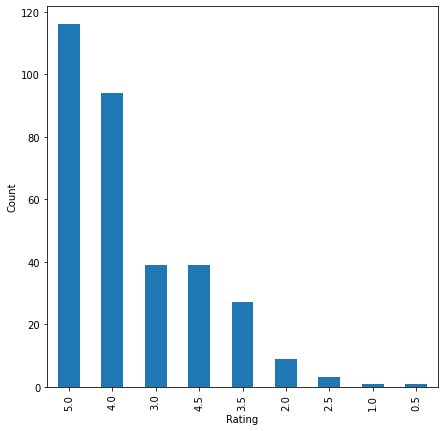

In [11]:
# Plotting distributions of ratings for 329 interactions with movieid 356
# Let us fix the size of the figure
plt.figure(figsize = (7, 7))
rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind = 'bar')
# This gives a label to the variable on the x-axis
plt.xlabel('Rating')
# This gives a label to the variable on the y-axis
plt.ylabel('Count')
# This displays the plot
plt.show()

- We can see that this movie has been liked by the majority of users, as the count of ratings 5 and 4 is higher than the count of lower ratings.
- There can be movies with very high interactions but the count of ratings 1 and 2 may be much higher than the count for ratings 4 or 5 which would imply that the movie is disliked by the majority of the users.

#### **Which user interacted the most with any movie in the dataset?**

In [12]:
# Counting the number of movies each user has watched
rating['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: userId, Length: 610, dtype: int64

- The user with userId: 414 has interacted with the most number of movies, i.e., 2,698 times.
- But still, there is a possibility of 9724 - 2698 = 7026 more interactions as we have 9724 unique movies in our dataset. For those 7026 remaining movies, we can build a recommendation system to predict which movies are most likely to be watched by this user.

#### **What is the distribution of the user-movie interactions in this dataset?**

In [13]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: movieId, Length: 610, dtype: int64

## **Model 1: Create Rank-Based Recommendation System**
- Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have cold start problem. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to him, as the user did not have any historical interactions available in the dataset. In those cases, we can use a rank-based recommendation system to recommend movies to the new user.

**To build the rank-based recommendation system, we take the average of all the ratings provided to each movie and then rank them based on their average rating.**

In [14]:
# Calculate average ratings for each movie
average_rating = rating.groupby('movieId').mean()['rating']

# Calculate the count of ratings for each movie
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

In [15]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7
5,3.071429,49


Create a function to find the top n movies for a recommendation based on the average ratings of movies. We can also add a threshold for a minimum number of interactions for a movie to be considered for recommendation.

In [16]:
def top_n_movies(data, n, min_interaction = 100):
    # Finding movies with interactions greater than the minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    # Sorting values with respect to the average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)
    return recommendations.index[:n]

### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [17]:
list(top_n_movies(final_rating, 5, 50))

[318, 858, 2959, 1276, 750]

### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [18]:
list(top_n_movies(final_rating, 5, 100))

[318, 858, 2959, 1221, 48516]

### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [19]:
list(top_n_movies(final_rating, 5, 200))

[318, 2959, 50, 260, 527]

## **Model 2: Collaborative Filtering Based Recommendation System**

In this type of recommendation system, we do not need any information about the user or item. We only need user-item interaction data to build a collaborative recommendation system. For example:

- Ratings provided by users. For example, ratings of books on goodread, movie ratings on imdb, etc.
- Likes of users on different facebook posts, likes on youtube videos, etc.
- Use/buying of a product by users. For example, buying different items on e-commerce sites.
- Reading of articles by readers on various blogs.

**Types of Collaborative Filtering:**

1.Similarity/Neighborhood-based
- User-User similarity-based
- Item-Item similarity-based

2 . Model-based

### **Building a baseline user-user similarity based recommendation system**

In [20]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633995 sha256=f895bfe756e95ce88fa87183cc8487388328a7857a6166f11a07813189291162
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [21]:
# To compute the accuracy of models
from surprise import accuracy
# Class to parse a file containing ratings, data should be in structure - user; item; rating
from surprise.reader import Reader
# Class for loading datasets
from surprise.dataset import Dataset
# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV
# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split
# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic
# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
# for implementing K-Fold cross-validation
from surprise.model_selection import KFold
# For implementing clustering-based recommendation system
from surprise import CoClustering

In [22]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)  
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

- To compute precision and recall, a threshold of 3.5 and k value of 10 is taken for the recommended and relevant ratings.
- In the present case, precision and recall, both need to be optimized as the service provider would like to minimize both the losses discussed above. Hence, the correct performance measure is the F_1 score.

In [23]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

- Ready to build the first baseline similarity-based recommendation system using the cosine similarity.
- KNNBasic is an algorithm that is also associated with the surprise package. It is used to find the desired similar items among a given set of items.

In [24]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the train set, and predict ratings for the test set
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 10
precision_recall_at_k(sim_user_user)

RMSE: 0.9823
Precision:  0.757
Recall:  0.542
F_1 score:  0.632


- We have calculated RMSE to check how far the overall predicted ratings are from the actual ratings.
- Intuition of Recall: We are getting a recall of ~0.54, which means out of all the relevant movies 54% are recommended.
- Intuition of Precision: We are getting a precision of ~ 0.76, which means out of all the recommended movies 76% are relevant.
- Here F_1 score of the baseline model is ~0.63. It indicates that mostly recommended movies were relevant and relevant movies were recommended. We will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.

#### **predict the rating for the user with userId = 4 and the movie with movieId = 10**

In [25]:
# Predicting rating for a sample user with an interacted movie
sim_user_user.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.41   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.4133289774831344, details={'actual_k': 40, 'was_impossible': False})

- The above output shows that the actual rating is not so far from the predicted rating for this user-item pair by this user-user-similarity-based baseline model.
- The output also contains "actual_k". It is the value of K in KNN that is used while training the model. The default value is 40.

In [26]:
rating[rating.movieId == 3].userId.unique()

array([  1,   6,  19,  32,  42,  43,  44,  51,  58,  64,  68,  91, 100,
       102, 116, 117, 150, 151, 169, 179, 217, 226, 240, 269, 270, 288,
       289, 294, 302, 307, 308, 321, 330, 337, 368, 410, 414, 448, 456,
       470, 477, 480, 492, 501, 544, 552, 555, 588, 590, 594, 599, 608])

- As the above list does not contain user id 4, we can say that user with user id 4 has not seen the movie with movieId 3.

#### **predicting the rating for the same userId = 4 but for a movie with which this user has not interacted yet, i.e., movieId = 3.**

In [27]:
# Predicting rating for a sample user with a non interacted movie
sim_user_user.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.260929007645626, details={'actual_k': 40, 'was_impossible': False})

### **Improving similarity-based recommendation system by tuning its hyperparameters**

In [28]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [30, 40, 50], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-Fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on data
gs.fit(data)

# Printing the best RMSE score
print(gs.best_score['rmse'])

# Printing the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9485382469024746
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


### **Build the final model by using the optimal values of the hyperparameters, which we received by using the grid search cross-validation.**

In [29]:
# Using the optimal similarity measure for user-user collaborative filtering
sim_options = {'name': 'msd',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 3, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9467
Precision:  0.762
Recall:  0.554
F_1 score:  0.642


- We can see from above that after tuning hyperparameters, F_1 score of the tuned model has increased slightly in comparison to the baseline model. Along with this, the RMSE of the model has gone down as compared to the model before hyperparameter tuning. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

#### **Predict the rating for the user with userId = 4 and the movie with movieId = 10**

In [30]:
sim_user_user_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.50   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.497691535784751, details={'actual_k': 30, 'was_impossible': False})

- If we compare the predicted rating with the actual raring, we can say that the predicted rating by the tuned model is closer to the actual rating in comparison to the prediction by the baseline model.

#### **Predicting the rating for the same userId = 4 but for a movie with which this user has not interacted before, i.e., movieId = 3**

In [31]:
sim_user_user_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.45   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.4530529132024763, details={'actual_k': 30, 'was_impossible': False})

### **Identifying similar users to a given user (nearest neighbors)**
- We can also find out similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to userId = 4 based on the msd distance metric.

In [32]:
sim_user_user_optimized.get_neighbors(4, k = 5)

[89, 90, 91, 181, 230]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**
we will be implementing a function where the input parameters are:

- data: The rating dataset.
- user_id: The user id for which we want the recommendations.
- top_n: The number of movies we want to recommend.
- algo: The algorithm we want to use for predicting the ratings.
- The output of the function is a set of top_n items recommended for the given user_id based on the given algorithm.

In [33]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'userId', columns = 'movieId', values = 'rating')
    
    # Extracting those movie IDs which the user ID has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie IDs which user ID has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie IDs by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    # Returing top n highest predicted rating movies for this user
    return recommendations[:top_n]

#### **Predicted top 5 movies for userId = 4 using the similarity-based recommendation system.**

In [34]:
# Making top 5 recommendations for userId 4 using the similarity-based recommendation system
recommendations = get_recommendations(rating, 4, 5, sim_user_user_optimized)

In [35]:
# Building the dataframe for above recommendations with columns "movieId" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings'])

,movieId,predicted_ratings
0,3404,5.000000
1,7121,5.000000
2,6460,4.844207
3,115122,4.813285
4,1178,4.808807


### **Correcting the Ratings and Ranking the above movies**
- While comparing the ratings of two movies, it is not only the ratings that describe the likelihood of the user to interact with that movie. Along with the rating, the number of users who have watched that movie also become important to consider. Due to this, we have calculated the "corrected_ratings" for each movie. Generally, higher the "rating_count" of a movie, more reliable the rating is. To interpret the above concept, a movie rated 4 with rating_count 3 is less liked in comparison to a movie rated 3 with a rating count of 50. It has been empirically found that the likelihood of the movie is directly proportional to the inverse of the square root of the rating_count of the movie.

In [36]:
def ranking_movies(recommendations, final_rating):

  # Sort the movies based on ratings count
  ranked_movies = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

  # Merge with the recommended movies to get predicted ratings
  ranked_movies = ranked_movies.merge(pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings']), on = 'movieId', how = 'inner')

  # Rank the movies based on corrected ratings
  ranked_movies['corrected_ratings'] = ranked_movies['predicted_ratings'] - 1 / np.sqrt(ranked_movies['rating_count'])

  # Sort the movies based on corrected ratings
  ranked_movies = ranked_movies.sort_values('corrected_ratings', ascending = False)
  
  return ranked_movies

In [37]:
# Applying the ranking movies function and sorting it based on corrected ratings
ranking_movies(recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
1,3404,6,5.000000,4.591752
0,1178,12,4.808807,4.520132
3,7121,4,5.000000,4.500000
2,6460,5,4.844207,4.396993
4,115122,3,4.813285,4.235934


### **Item-Item Similarity-Based Collaborative Filtering Recommendation Systems**

In [38]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# The KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9800
Precision:  0.609
Recall:  0.464
F_1 score:  0.527


- Here, F_1 score of the baseline model is ~0.53. We will try to improve this later by tuning different hyperparameters of this algorithm using GridSearchCV.

#### **predict the rating for the user with userId = 4 and the movie with movieId = 10**

In [39]:
# Predicting rating for a sample user with an interacted movie
sim_item_item.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.63   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6257369831511945, details={'actual_k': 40, 'was_impossible': False})

- The above output shows that the actual rating for this user-item pair is 4, and the predicted rating is close to that.

#### **predicting the rating for the same userId = 4 but for a movie with which this user has not interacted yet, i.e., movieId = 3.**

In [40]:
# Predicting rating for a sample user with a non interacted movie
sim_item_item.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.67   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6748659322681623, details={'actual_k': 40, 'was_impossible': False})

### **Improving similarity-based recommendation system by tuning its hyperparameters**

In [41]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-Fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9171927610615155
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


In [42]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9160
Precision:  0.678
Recall:  0.499
F_1 score:  0.575


- We can observe that after tuning hyperparameters, F_1 score of the model is better than the baseline model. Along with this, the RMSE of the model has gone down in comparison to the model with default hyperparameters. Hence, we can say that the model performance has improved after hyperparameter tuning.

#### **predict the rating for the user with userId = 4 and the movie with movieId = 10**

In [43]:
sim_item_item_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.26   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.2569148418342952, details={'actual_k': 30, 'was_impossible': False})

- We observe that the predicted rating by the baseline model was closer to the actual rating in comparison to that by the optimized model. This might be because, although the overall score has increased, the prediction for this particular user is not that good.

#### **predicting the rating for the same userId = 4 but for a movie which this user has not interacted before, i.e., movieId = 3**

In [44]:
sim_item_item_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.57   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.574650247164053, details={'actual_k': 30, 'was_impossible': False})

### **Identifying similar items to a given item (nearest neighbors)**

In [45]:
sim_item_item_optimized.get_neighbors(3, k = 5)

[26, 83, 248, 254, 343]

#### **Predicting top 5 movies for userId = 4 using the similarity-based recommendation system.**

In [46]:
# Making top 5 recommendations for userId 4 using the similarity-based recommendation system
recommendations = get_recommendations(rating, 4, 5, sim_item_item_optimized)

In [47]:
# Building the dataframe for above recommendations with columns "movieId" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['movieId', 'predicted_ratings'])

,movieId,predicted_ratings
0,5706,4.771028
1,176579,4.748016
2,25959,4.744049
3,2149,4.730439
4,56176,4.724374


In [48]:
# Applying the "ranking_movies" function and sorting it based on corrected ratings
ranking_movies(recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
0,2149,4,4.730439,4.230439
1,56176,3,4.724374,4.147023
2,5706,1,4.771028,3.771028
3,176579,1,4.748016,3.748016
4,25959,1,4.744049,3.744049


## **Model 3: Matrix Factorization**

### **Building a baseline matrix factorization recommendation system**

In [49]:
# Using SVD with matrix factorization
svd = SVD(random_state = 1)

# Training the algorithm on the training dataset
svd.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(svd)

RMSE: 0.8797
Precision:  0.738
Recall:  0.507
F_1 score:  0.601


- We can observe that the F_1 score for the matrix factorization model on the test set is lower in comparison to the F_1 score for the user-user-similarity recommendation system and optimized user-user similarity-based recommendation system.

#### **predict the rating for the user with userId = 4 and the movie with movieId = 10**

In [50]:
# Making prediction for userId 4 and movieId 10
svd.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.33   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.333359479354037, details={'was_impossible': False})

#### **predicting rating for the same userId = 4 but for a movie which this user has not interacted before, i.e., movieId = 3**

In [51]:
# Making prediction for userid 4 and movieId 3
svd.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 2.94   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=2.9386110726567756, details={'was_impossible': False})

### **Improving matrix factorization based recommendation system by tuning its hyperparameters**
we will be tuning only three hyperparameters:
- n_epochs: The number of iterations of the SVD algorithm.
- lr_all: The learning rate for all the parameters.
- reg_all: The regularization term for all the parameters.

In [52]:
# Set the parameter space to do hyperparameter tuning
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-Fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8725254177992737
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [53]:
# Building the optimized SVD model using optimal hyperparameters search
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(svd_optimized)

RMSE: 0.8752
Precision:  0.731
Recall:  0.511
F_1 score:  0.602


- We can observe that after tuning hyperparameters, the model performance has not improved by much.

#### **predict the rating for the user with userId = 4 and the movie with movieId = 10**

In [54]:
# Using svd_algo_optimized model to recommend for userId 4 and movieId 10
svd_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.39   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.3892642624049993, details={'was_impossible': False})

In [55]:
# Using svd_algo_optimized model to recommend for userId 4 and movieId 3 with unknown baseline rating
svd_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.20   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.20286300753659, details={'was_impossible': False})

### **recommend the movies using the optimized svd model.**

In [56]:
# Getting top 5 recommendations for userId 4 using "svd_algo_optimized" algorithm
svd_recommendations = get_recommendations(rating, 4, 5, svd_optimized)

In [57]:
# Ranking movies based on above recommendations
ranking_movies(svd_recommendations, final_rating)

,movieId,rating_count,predicted_ratings,corrected_ratings
0,1178,12,4.446400,4.157725
1,177593,8,4.380428,4.026875
2,106642,7,4.379596,4.001631
3,3266,6,4.332485,3.924236
4,7121,4,4.342665,3.842665


## **Conclusion**
Built recommendation systems using four different algorithms. They are as follows:
- Rank-based using averages
- User-User similarity-based collaborative filtering
- Item-Item similarity-based collaborative filtering
- Model-based collaborative filtering (matrix factorization)
- The surprise library was used to demonstrate"user-user similarity-based collaborative filtering," "item-item similarity-based collaborative filtering," and "model-based collaborative filtering (matrix factorization)" algorithms. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and related predictions are created using the optimal hyperparameters.
- For performance evaluation of these models precision@k and recall@k are used. Using these two metrics, the F_1 score is calculated for each working model.
- Overall, the user-user similarity-based recommendation system has given the best performance in terms of the F1-Score.